In [21]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import rasterio as rio
import geopandas as gpd

import os
import json

from pprint import pprint
from pyretechnics.fuel_models import get_fuel_model, moisturize

from sklearn.preprocessing import StandardScaler, LabelEncoder,OneHotEncoder, LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score,precision_score,recall_score,roc_curve,auc,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from_vals = [
    91,92,93,98,99,
    101,102,103,104,105,106,107,108,109,
    121,122,123,124,
    141,142,143,144,145,146,147,148,149,
    161,162,163,164,165,
    181,182,183,184,185,186,187,188,189,
    201,202,203,204
]

to_vals = [
    1,1,1,1,1,
    2,2,2,2,2,2,2,2,2,
    3,3,3,3,
    4,4,4,4,4,4,4,4,4,
    5,5,5,5,5,
    6,6,6,6,6,6,6,6,6,
    7,7,7,7
]

lf_file = os.path.join('D:\\','SIG','fuels','eo-fuels-extrapolation','data','LF2024_FBFM40.csv')
lfdf = pd.read_csv(lf_file)

#Pyrome Groups by Ecological Similarity, selected by Kayla
inland_nw_dry_mixed_conifer = [7,16,6,14,18]

dry_moist_mixed_conifer_w_oak_wide_elevation_range = [4,17,26]

sagebrush_grassland_w_forest_pockets = [78,20,5,19]

In [2]:


static_fuel_model_number  = 1   # R01
dynamic_fuel_model_number = 101 # GR1

static_fuel_model  = get_fuel_model(static_fuel_model_number)
dynamic_fuel_model = get_fuel_model(dynamic_fuel_model_number)

print("Static Fuel Model: R01")
pprint(static_fuel_model)

print("\nDynamic Fuel Model: GR1")
pprint(dynamic_fuel_model)

fuel_moisture = (
    0.05, # dead_1hr
    0.10, # dead_10hr
    0.15, # dead_100hr
    0.00, # dead_herbaceous (will be set by moisturize for dynamic fuel models)
    0.30, # live_herbaceous
    0.50, # live_woody
)



#Wildland Fuel Moisture Values, selected by Kayla
low_severity = (
    0.07, # dead_1hr
    0.10, # dead_10hr
    0.15, # dead_100hr
    0.00, # dead_herbaceous (will be set by moisturize for dynamic fuel models)
    0.90, # live_herbaceous
    1.20  # live_woody
)

moderate_severity = (
    0.05, # dead_1hr
    0.07, # dead_10hr
    0.10, # dead_100hr
    0.00, # dead_herbaceous (will be set by moisturize for dynamic fuel models)
    0.70, # live_herbaceous
    1.00  # live_woody
)

high_severity = (
    0.03, # dead_1hr
    0.04, # dead_10hr
    0.05, # dead_100hr
    0.00, # dead_herbaceous (will be set by moisturize for dynamic fuel models)
    0.20, # live_herbaceous
    0.80  # live_woody
)

moisture_severities = {
    'low':low_severity,
    'moderate':moderate_severity,
    'high':high_severity
}

Static Fuel Model: R01
{'M_f': (0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
 'M_x': (0.11999999731779099,
         0.11999999731779099,
         0.11999999731779099,
         0.0,
         0.0,
         0.0),
 'S_T': (0.05550000071525574,
         0.05550000071525574,
         0.05550000071525574,
         0.05550000071525574,
         0.05550000071525574,
         0.05550000071525574),
 'S_e': (0.009999999776482582,
         0.009999999776482582,
         0.009999999776482582,
         0.009999999776482582,
         0.009999999776482582,
         0.009999999776482582),
 'burnable': True,
 'delta': 1.0,
 'dynamic': False,
 'exp_A_sigma': (0.9613386392593384, 0.0, 0.0, 0.0, 0.0, 0.0),
 'f_i': (0.0, 0.0),
 'f_ij': (0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
 'firemod_size_classes': (1.0, 6.0, 6.0, 6.0, 6.0, 6.0),
 'g_ij': (0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
 'h': (8000.0, 8000.0, 8000.0, 8000.0, 8000.0, 8000.0),
 'number': 1,
 'rho_p': (32.0, 32.0, 32.0, 32.0, 32.0, 32.0),
 'sigma': (3500.0, 0.0, 0.0, 0.0, 0.0, 0.0)

In [3]:
from pyretechnics.surface_fire import calc_surface_fire_behavior_no_wind_no_slope

records = []

for fuel_model_code in from_vals:
    for severity_level in moisture_severities.keys():
        fuel_model = get_fuel_model(fuel_model_code)
        moisturized_fuel_model = moisturize(fuel_model,moisture_severities[severity_level])

        behavior = calc_surface_fire_behavior_no_wind_no_slope(moisturized_fuel_model)
        record = {'code':fuel_model_code,'moisture_severity':severity_level,'spread_rate':behavior['base_spread_rate'],'fireline_intensity':behavior['base_fireline_intensity']}
        records.append(record)

fuel_model_behavior = pd.DataFrame.from_records(records)
fuel_model_behavior['parent_code'] = fuel_model_behavior['code'].map(lambda x: to_vals[int(np.nonzero(np.array(from_vals)==x)[0])])
fuel_model_behavior = fuel_model_behavior.merge(lfdf[['VALUE','FBFM40']],left_on='code',right_on='VALUE')

lf_groups = ['NB','GR','GS','SH','TU','TL','SB']
fuel_model_behavior['lf_group'] = fuel_model_behavior['parent_code'].map(lambda x: lf_groups[x-1])

C:\Users\rpdemilt\AppData\Local\Temp\ipykernel_60868\2675970913.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fuel_model_behavior['parent_code'] = fuel_model_behavior['code'].map(lambda x: to_vals[int(np.nonzero(np.array(from_vals)==x)[0])])


<Axes: xlabel='moisture_severity', ylabel='code'>

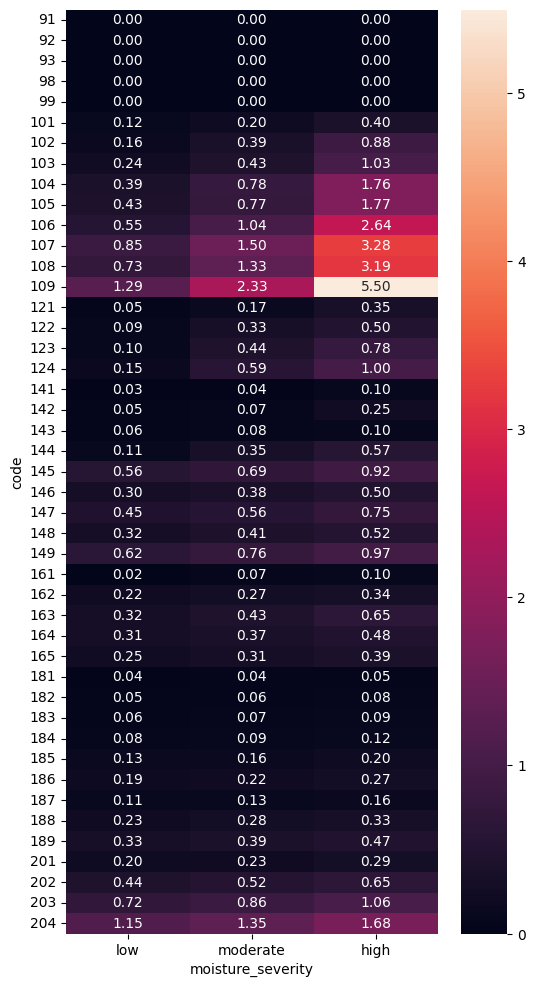

In [4]:
spread_rate_table = fuel_model_behavior.pivot(index='code',columns='moisture_severity',values='spread_rate')

plt.figure(figsize=(6,12))
sns.heatmap(spread_rate_table[['low','moderate','high']],annot=True,fmt='.2f')

<Axes: xlabel='moisture_severity', ylabel='code'>

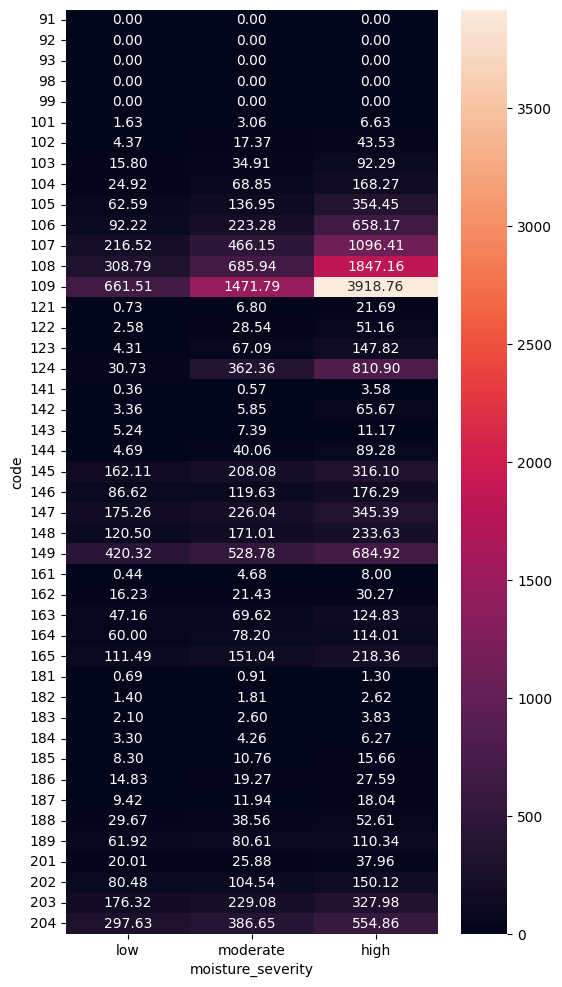

In [5]:
fireline_intensity_table = fuel_model_behavior.pivot(index='code',columns='moisture_severity',values='fireline_intensity')

plt.figure(figsize=(6,12))
sns.heatmap(fireline_intensity_table[['low','moderate','high']],annot=True,fmt='.2f')

<Axes: xlabel='spread_rate', ylabel='fireline_intensity'>

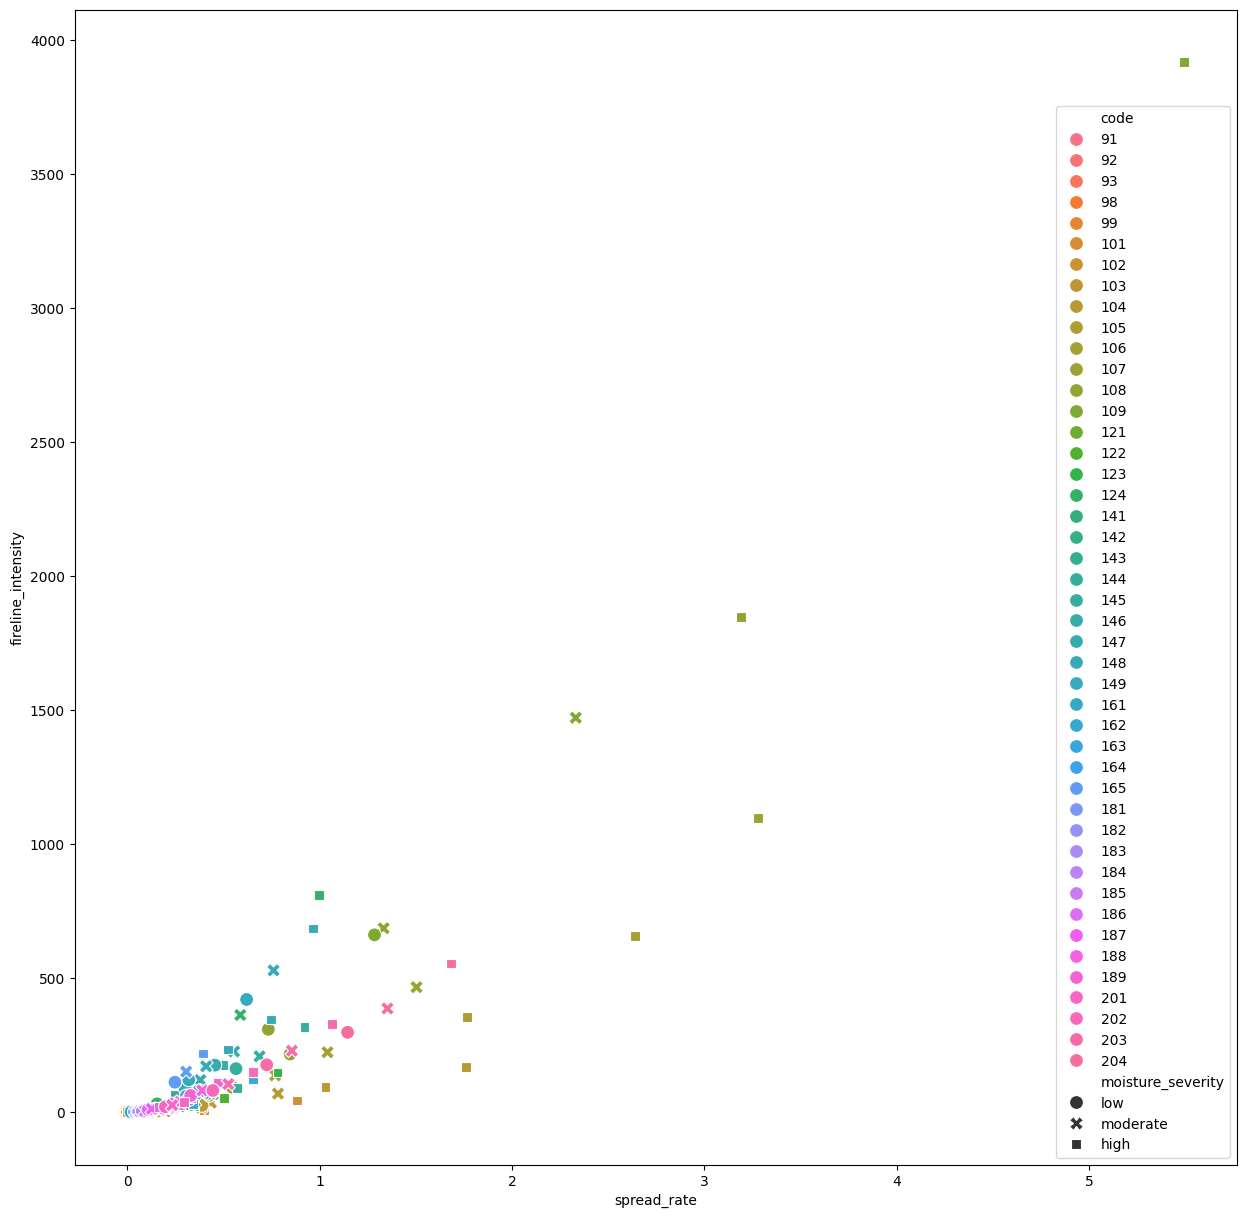

In [6]:

plt.figure(figsize=(15,15))
sns.scatterplot(fuel_model_behavior,x='spread_rate',y='fireline_intensity',hue='code',style='moisture_severity',s=100,legend='full',palette=sns.color_palette('husl',n_colors=len(fuel_model_behavior['code'].unique())))

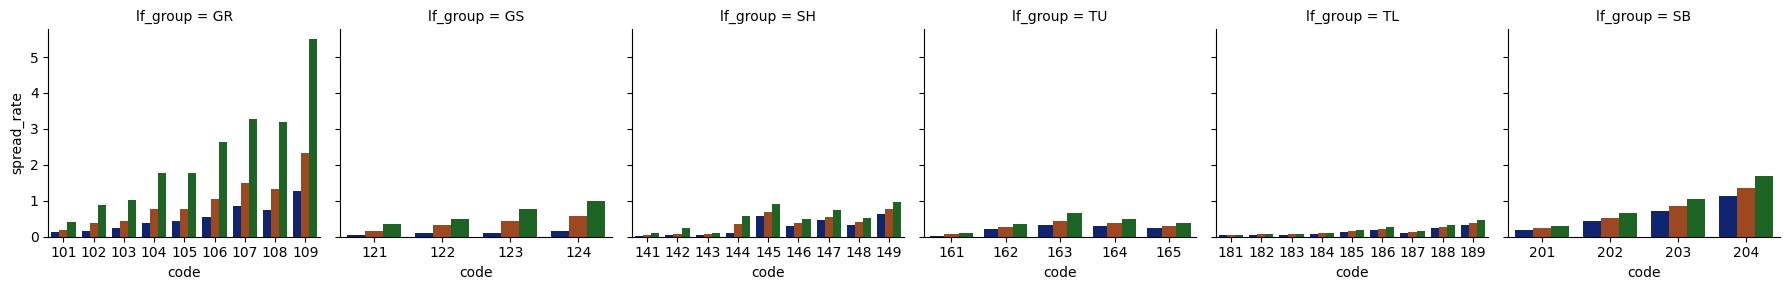

In [7]:
g = sns.FacetGrid(fuel_model_behavior[fuel_model_behavior['lf_group'] != 'NB'],col='lf_group',sharex=False)
g.map_dataframe(sns.barplot,x='code',y='spread_rate',hue='moisture_severity',palette='dark')

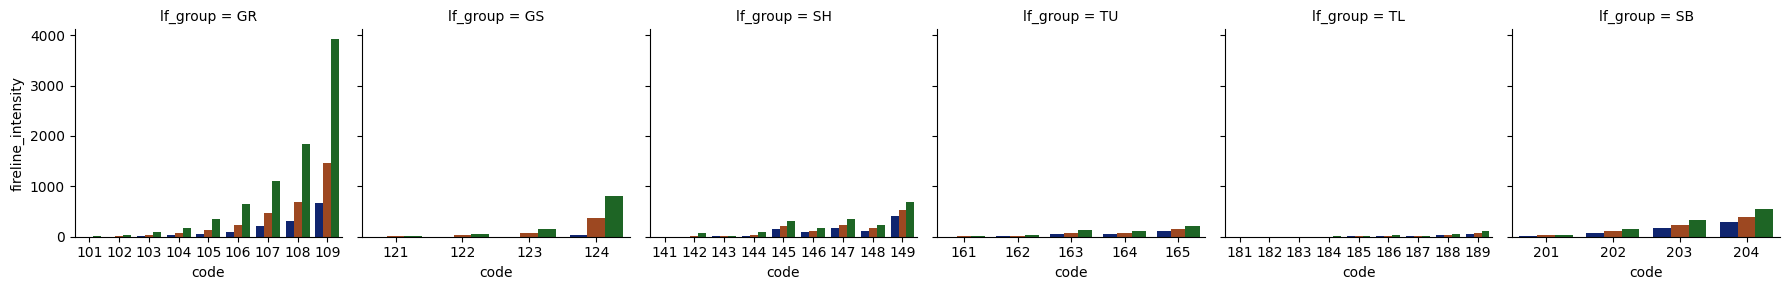

In [8]:
g = sns.FacetGrid(fuel_model_behavior[fuel_model_behavior['lf_group'] != 'NB'],col='lf_group',sharex=False)
g.map_dataframe(sns.barplot,x='code',y='fireline_intensity',hue='moisture_severity',palette='dark')

---

Load Dataset

---

In [9]:
root_file = os.path.join('D:\\','SIG','fuels','eo-fuels-extrapolation','data','FuelsData')

pyromes= [
    33
]
eval_pyromes = [
    30
]
years = [2023]

def load_data(pyromes,years,root_file):
    yearly_frames = []
    for pyrome in pyromes:
        for year in years:
            year_csv_file = os.path.join(root_file,f'stratified_sample_fbfm40_30m_{pyrome}_{year}.csv')
            year_fuels_sample = pd.read_csv(year_csv_file)
            yearly_frames.append(year_fuels_sample)

    fuels_frame = pd.concat(yearly_frames)

    return fuels_frame
fuels_sample = load_data(pyromes,years,root_file)

def make_gdf(fuels_frame):
    fuels_sample_loc = fuels_frame.copy()

    geo = fuels_frame['.geo']
    fuels_sample_loc['longitude'], fuels_sample_loc['latitude'] = geo.map(lambda x: list(json.loads(x)['coordinates'])[0]), geo.map(lambda x: list(json.loads(x)['coordinates'])[1])

    fuels_sample_loc[['latitude','longitude']]
    fuels_sample_loc.drop(columns=['system:index','.geo'],inplace=True)

    fuels_sample_gdf = gpd.GeoDataFrame(fuels_sample_loc,geometry=gpd.points_from_xy(fuels_sample_loc.longitude,fuels_sample_loc.latitude),crs='EPSG:4326').to_crs('EPSG:5070')

    return fuels_sample_gdf

def append_veg_features(gdf):
    #evt
    evt_file = os.path.join('D:\\','SIG','fuels','eo-fuels-extrapolation','data','LF2023_EVT_CONUS')
    evt_classes_csv = os.path.join(evt_file,'CSV_Data','LF2023_EVT.csv')
    evt_tifffile =os.path.join(evt_file,'Tif','LF2023_EVT_CONUS.tif')
    evt_classes = pd.read_csv(evt_classes_csv)
    evt_data = rio.open(evt_tifffile)

    #evc
    evc_file = os.path.join('D:\\','SIG','fuels','eo-fuels-extrapolation','data','LF2023_EVC_CONUS')
    evc_data_description_csv = os.path.join(evc_file,'CSV_Data','LF2023_EVC.csv')
    evc_tifffile =os.path.join(evc_file,'Tif','LF2023_EVC_CONUS.tif')
    evc_data_description  = pd.read_csv(evc_data_description_csv)
    evc_data = rio.open(evc_tifffile)

    #evh
    evh_file = os.path.join('D:\\','SIG','fuels','eo-fuels-extrapolation','data','LF2023_EVH_CONUS')
    evh_data_description_csv = os.path.join(evh_file,'CSV_Data','LF2023_EVH.csv')
    evh_tifffile =os.path.join(evh_file,'Tif','LF2023_EVH_CONUS.tif')
    evh_data_description  = pd.read_csv(evh_data_description_csv)
    evh_data = rio.open(evh_tifffile)

    #bps
    bps_file = os.path.join('D:\\','SIG','fuels','eo-fuels-extrapolation','data','LF2020_BPS_220_CONUS')
    bps_classes_csv = os.path.join(bps_file,'CSV_Data','LF20_BPS_220.csv')
    bps_tifffile =os.path.join(bps_file,'Tif','LC20_BPS_220.tif')
    bps_classes = pd.read_csv(bps_classes_csv)
    bps_data = rio.open(bps_tifffile)

    #nlcd
    nlcd_file = evt_file = os.path.join('D:\\','SIG','fuels','eo-fuels-extrapolation','data','Annual_NLCD_LndCov_2023_CU_C1V1','Annual_NLCD_LndCov_2023_CU_C1V1.tif')
    nlcd_data = rio.open(nlcd_file)

    coord_list = [(x,y) for x,y in zip(gdf['geometry'].x,gdf['geometry'].y)]
    gdf['evt'] = [x[0] for x in evt_data.sample(coord_list)]
    gdf['evc'] = [x[0] for x in evc_data.sample(coord_list)]
    gdf['evh'] = [x[0] for x in evh_data.sample(coord_list)]
    gdf['bps'] = [x[0] for x in bps_data.sample(coord_list)]
    gdf['nlcd'] = [x[0] for x in nlcd_data.sample(coord_list)]

    gdf = gdf.merge(evt_classes[['LFRDB','EVT_NAME','EVT_ORDER','EVT_CLASS','EVT_SBCLS']],left_on='evt',right_on='LFRDB')

    evc_data_description = evc_data_description.rename(columns={'CLASSNAMES':'EVC_CLASS'})
    gdf = gdf.merge(evc_data_description[['VALUE','EVC_CLASS']],left_on='evc',right_on='VALUE')

    def assign_tree_cover(record):

        if (record['evc'] > 100) and (record['evc'] < 200):
            tree_cover = (record['evc'] % 100) / 100.0
        else:
            tree_cover = 0

        return tree_cover

    def assign_shrub_cover(record):

        if (record['evc'] > 200) and (record['evc'] < 300):
                shrub_cover = (record['evc'] % 100) / 100.0
        else:
            shrub_cover = 0

        return shrub_cover

    def assign_herb_cover(record):

        if (record['evc'] > 300) and (record['evc'] < 400):
                herb_cover = (record['evc'] % 100) / 100.0
        else:
            herb_cover = 0

        return herb_cover


    gdf['tree_cover'] = gdf.apply(assign_tree_cover,axis=1)
    gdf['shrub_cover'] = gdf.apply(assign_shrub_cover,axis=1)
    gdf['herb_cover'] = gdf.apply(assign_herb_cover,axis=1)

    evh_data_description = evh_data_description.rename(columns={'CLASSNAMES':'EVH_CLASS'})
    gdf = gdf.merge(evh_data_description[['VALUE','EVH_CLASS']],left_on='evh',right_on='VALUE')

    def assign_tree_height(record):

        if (record['evh'] > 100) and (record['evh'] < 200):
            tree_height = (record['evh'] % 100)
        else:
            tree_height = 0

        return tree_height

    def assign_shrub_height(record):

        if (record['evh'] > 200) and (record['evh'] < 300):
                shrub_height = (record['evh'] % 100) / 10.0
        else:
            shrub_height = 0

        return shrub_height

    def assign_herb_height(record):

        if (record['evh'] > 300) and (record['evh'] < 400):
                herb_height = (record['evh'] % 100) / 10.0
        else:
            herb_height = 0

        return herb_height


    gdf['tree_height'] = gdf.apply(assign_tree_height,axis=1)
    gdf['shrub_height'] = gdf.apply(assign_shrub_height,axis=1)
    gdf['herb_height'] = gdf.apply(assign_herb_height,axis=1)


    bps_classes = bps_classes.rename(columns={'GROUPVEG':'BPS_CLASS'})
    gdf = gdf.merge(bps_classes[['VALUE','BPS_NAME','BPS_CLASS']],left_on='bps',right_on='VALUE')

    return gdf

    


feature_list = fuels_sample.columns.to_list()
feature_list.remove('system:index')
feature_list.remove('.geo')
for x in ['EVT','BPS','EVC','EVH','ESP']:
    feature_list.remove(x)

alphaearth_features = [f'A{str(i).zfill(2)}' for i in range(64)]
label_list = ['FBFM40','FBFM40Parent']
feature_list_wo_alphaearth = [feature for feature in feature_list if feature not in (alphaearth_features +label_list)]

feature_list_spectral = [feature for feature in feature_list if (feature[0] == 'B')]

feature_list_biophysical_w_spx = [feature for feature in feature_list if feature not in (alphaearth_features + label_list + feature_list_spectral)]

fuels_labels = fuels_sample[label_list]

# fuels_data_alphaearth = fuels_sample[alphaearth_features]
# fuels_data_wo_alphaearth = fuels_sample[feature_list_wo_alphaearth]
# fuels_data_full = fuels_sample[alphaearth_features + feature_list_wo_alphaearth]

In [10]:
inland_nw_dry_mixed_conifer = [7,16,6,14,18]

dry_moist_mixed_conifer_w_oak_wide_elevation_range = [4,17,26]

sagebrush_grassland_w_forest_pockets = [78,20,5,19]

datasets = {}

fuels_region_comparison_root = os.path.join('D:\\','SIG','fuels','eo-fuels-extrapolation','data','FuelsData4')

for pyrome in (inland_nw_dry_mixed_conifer + dry_moist_mixed_conifer_w_oak_wide_elevation_range + sagebrush_grassland_w_forest_pockets):
    sample = append_veg_features(make_gdf(load_data([pyrome],years,fuels_region_comparison_root)))
    datasets[pyrome] = sample

In [11]:
fuels_sample_loc = fuels_sample.copy()

geo = fuels_sample['.geo']
fuels_sample_loc['longitude'], fuels_sample_loc['latitude'] = geo.map(lambda x: list(json.loads(x)['coordinates'])[0]), geo.map(lambda x: list(json.loads(x)['coordinates'])[1])

fuels_sample_loc[['latitude','longitude']]
fuels_sample_loc.drop(columns=['system:index','.geo','EVT','BPS','EVH','EVC'],inplace=True)

fuels_sample_gdf = gpd.GeoDataFrame(fuels_sample_loc,geometry=gpd.points_from_xy(fuels_sample_loc.longitude,fuels_sample_loc.latitude),crs='EPSG:4326').to_crs('EPSG:5070')

In [12]:
nlcd_file = evt_file = os.path.join('D:\\','SIG','fuels','eo-fuels-extrapolation','data','Annual_NLCD_LndCov_2023_CU_C1V1','Annual_NLCD_LndCov_2023_CU_C1V1.tif')
nlcd_data = rio.open(nlcd_file)

---

EVC, EVH, EVT, BPS Examination

---

In [12]:
evt_file = os.path.join('D:\\','SIG','fuels','eo-fuels-extrapolation','data','LF2023_EVT_CONUS')

evt_classes_csv = os.path.join(evt_file,'CSV_Data','LF2023_EVT.csv')

evt_tifffile =os.path.join(evt_file,'Tif','LF2023_EVT_CONUS.tif')

evt_classes = pd.read_csv(evt_classes_csv)

evt_data = rio.open(evt_tifffile)

In [13]:
evc_file = os.path.join('D:\\','SIG','fuels','eo-fuels-extrapolation','data','LF2023_EVC_CONUS')
evc_data_description_csv = os.path.join(evc_file,'CSV_Data','LF2023_EVC.csv')

evc_tifffile =os.path.join(evc_file,'Tif','LF2023_EVC_CONUS.tif')

evc_data_description  = pd.read_csv(evc_data_description_csv)
evc_data = rio.open(evc_tifffile)

In [14]:
evh_file = os.path.join('D:\\','SIG','fuels','eo-fuels-extrapolation','data','LF2023_EVH_CONUS')
evh_data_description_csv = os.path.join(evh_file,'CSV_Data','LF2023_EVH.csv')

evh_tifffile =os.path.join(evh_file,'Tif','LF2023_EVH_CONUS.tif')

evh_data_description  = pd.read_csv(evh_data_description_csv)
evh_data = rio.open(evh_tifffile)

In [15]:
bps_file = os.path.join('D:\\','SIG','fuels','eo-fuels-extrapolation','data','LF2020_BPS_220_CONUS')

bps_classes_csv = os.path.join(bps_file,'CSV_Data','LF20_BPS_220.csv')

bps_tifffile =os.path.join(bps_file,'Tif','LC20_BPS_220.tif')

bps_classes = pd.read_csv(bps_classes_csv)

bps_data = rio.open(bps_tifffile)

In [16]:
coord_list = [(x,y) for x,y in zip(fuels_sample_gdf['geometry'].x,fuels_sample_gdf['geometry'].y)]
fuels_sample_gdf['evt'] = [x[0] for x in evt_data.sample(coord_list)]
fuels_sample_gdf['evc'] = [x[0] for x in evc_data.sample(coord_list)]
fuels_sample_gdf['evh'] = [x[0] for x in evh_data.sample(coord_list)]
fuels_sample_gdf['bps'] = [x[0] for x in bps_data.sample(coord_list)]
fuels_sample_gdf['nlcd'] = [x[0] for x in nlcd_data.sample(coord_list)]

In [17]:
fuels_sample_gdf = fuels_sample_gdf.merge(evt_classes[['LFRDB','EVT_NAME','EVT_ORDER','EVT_CLASS','EVT_SBCLS']],left_on='evt',right_on='LFRDB')

In [18]:
evc_data_description = evc_data_description.rename(columns={'CLASSNAMES':'EVC_CLASS'})
fuels_sample_gdf = fuels_sample_gdf.merge(evc_data_description[['VALUE','EVC_CLASS']],left_on='evc',right_on='VALUE')

def assign_tree_cover(record):

    if (record['evc'] > 100) and (record['evc'] < 200):
        tree_cover = (record['evc'] % 100) / 100.0
    else:
        tree_cover = 0

    return tree_cover

def assign_shrub_cover(record):

    if (record['evc'] > 200) and (record['evc'] < 300):
            shrub_cover = (record['evc'] % 100) / 100.0
    else:
        shrub_cover = 0

    return shrub_cover

def assign_herb_cover(record):

    if (record['evc'] > 300) and (record['evc'] < 400):
            herb_cover = (record['evc'] % 100) / 100.0
    else:
        herb_cover = 0

    return herb_cover


fuels_sample_gdf['tree_cover'] = fuels_sample_gdf.apply(assign_tree_cover,axis=1)
fuels_sample_gdf['shrub_cover'] = fuels_sample_gdf.apply(assign_shrub_cover,axis=1)
fuels_sample_gdf['herb_cover'] = fuels_sample_gdf.apply(assign_herb_cover,axis=1)

In [19]:
evh_data_description = evh_data_description.rename(columns={'CLASSNAMES':'EVH_CLASS'})
fuels_sample_gdf = fuels_sample_gdf.merge(evh_data_description[['VALUE','EVH_CLASS']],left_on='evh',right_on='VALUE')

def assign_tree_height(record):

    if (record['evh'] > 100) and (record['evh'] < 200):
        tree_height = (record['evh'] % 100)
    else:
        tree_height = 0

    return tree_height

def assign_shrub_height(record):

    if (record['evh'] > 200) and (record['evh'] < 300):
            shrub_height = (record['evh'] % 100) / 10.0
    else:
        shrub_height = 0

    return shrub_height

def assign_herb_height(record):

    if (record['evh'] > 300) and (record['evh'] < 400):
            herb_height = (record['evh'] % 100) / 10.0
    else:
        herb_height = 0

    return herb_height


fuels_sample_gdf['tree_height'] = fuels_sample_gdf.apply(assign_tree_height,axis=1)
fuels_sample_gdf['shrub_height'] = fuels_sample_gdf.apply(assign_shrub_height,axis=1)
fuels_sample_gdf['herb_height'] = fuels_sample_gdf.apply(assign_herb_height,axis=1)

In [20]:
bps_classes = bps_classes.rename(columns={'GROUPVEG':'BPS_CLASS'})
fuels_sample_gdf = fuels_sample_gdf.merge(bps_classes[['VALUE','BPS_NAME','BPS_CLASS']],left_on='bps',right_on='VALUE')

In [ ]:
fuels_inputs = fuels_sample_gdf[feature_list]
fuels_inputs_alphaearth = fuels_sample_gdf[alphaearth_features]
fuels_inputs_woalphaearth = fuels_sample_gdf[feature_list_wo_alphaearth]
fuels_inputs_spectral = fuels_sample_gdf[feature_list_spectral]
fuels_inputs_biophysical_w_spx = fuels_sample_gdf[feature_list_biophysical_w_spx]

fuels_target = fuels_sample_gdf['EVT_CLASS','BPS_CLASS']


scaler = StandardScaler()
encoder = LabelEncoder()

fuels_target_encode = encoder.fit_transform(fuels_target)

fuels_inputs_scaled = scaler.fit_transform(fuels_inputs)
fuels_inputs_alphaearth_scaled = scaler.fit_transform(fuels_inputs_alphaearth)
fuels_inputs_woalphaearth_scaled = scaler.fit_transform(fuels_inputs_woalphaearth)
fuels_inputs_spectral_scaled = scaler.fit_transform(fuels_inputs_spectral)
fuels_inputs_biophysical_w_spx_scaled = scaler.fit_transform(fuels_inputs_biophysical_w_spx)


fuels_sample_viz = fuels_sample_gdf.copy()

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

fuels_pca = pca.fit_transform(fuels_inputs_alphaearth_scaled)

fuels_sample_viz['PC1'] = fuels_pca[:,0]
fuels_sample_viz['PC2'] = fuels_pca[:,1]

plt.figure(figsize=(22,12))

sns.scatterplot(fuels_sample_viz,x='PC1',y='PC2',hue='EVT_CLASS')

<Axes: xlabel='TSNE1', ylabel='TSNE2'>

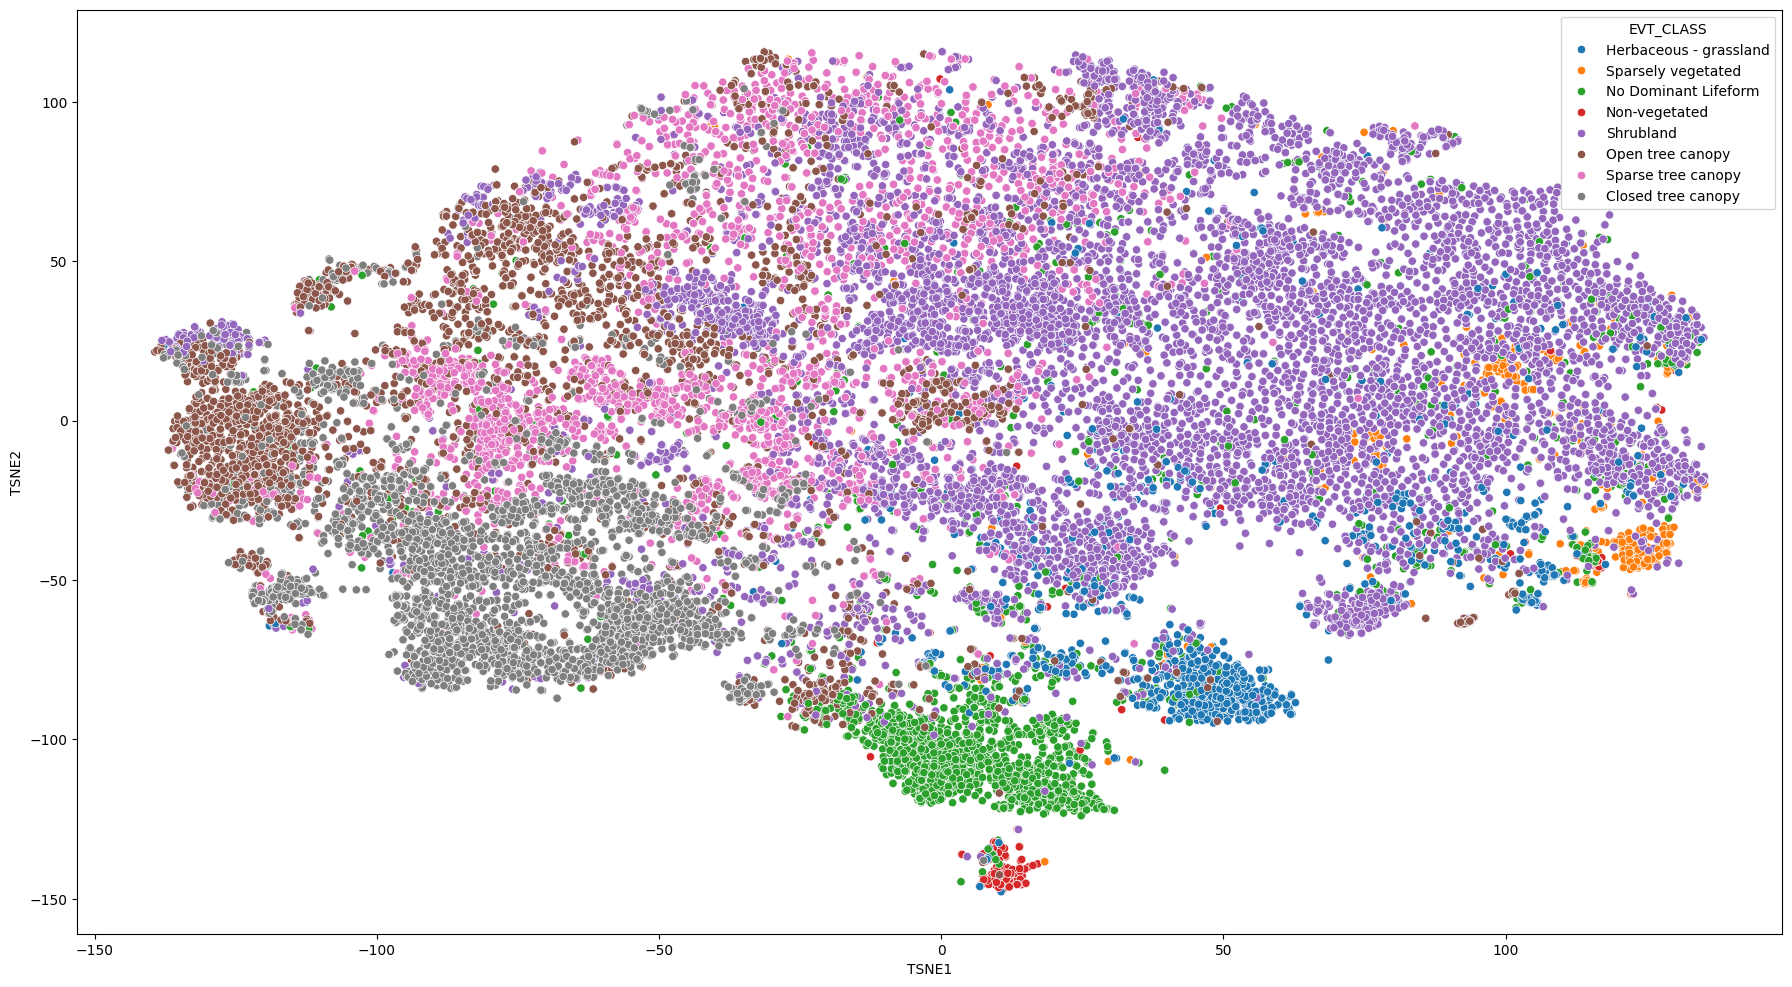

In [25]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=60,
    early_exaggeration=12,
    max_iter=2000,
    n_jobs=-1
)

fuels_tsne = tsne.fit_transform(fuels_inputs_scaled)

fuels_sample_viz['TSNE1'] = fuels_tsne[:,0]
fuels_sample_viz['TSNE2'] = fuels_tsne[:,1]

plt.figure(figsize=(22,12))

sns.scatterplot(fuels_sample_viz,x='TSNE1',y='TSNE2',hue='EVT_CLASS')

In [ ]:
continuous_features = feature_list + ['tree_cover','shrub_cover','herb_cover','tree_height','shrub_height','herb_height']
categorical_features = ['BPS_CLASS','EVT_CLASS']

# continuous_features = feature_list
# categorical_features = ['BPS_CLASS','EVT_CLASS']


label = ['FBFM40']
 
cont_scaler = StandardScaler()
cat_encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False)

label_encoder = LabelEncoder()

train_size = 0.7
test_size = 0.3

X_df = fuels_sample_gdf[continuous_features + categorical_features]
y_df = fuels_sample_gdf[label]

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df,y_df,test_size=test_size)


X_train_continuous_scaled = cont_scaler.fit_transform(X_train_df[continuous_features])
X_train_categorical_encode = cat_encoder.fit_transform(X_train_df[categorical_features])

X_test_continuous_scaled = cont_scaler.transform(X_test_df[continuous_features])
X_test_categorical_encode = cat_encoder.transform(X_test_df[categorical_features])

# X_train = np.concatenate([X_train_continuous_scaled,X_train_categorical_encode],axis=1)
# X_test = np.concatenate([X_test_continuous_scaled,X_test_categorical_encode],axis=1)

X_train = X_train_continuous_scaled
X_test = X_test_continuous_scaled

label_encoder.fit(from_vals)
y_train_encode = label_encoder.transform(y_train_df.to_numpy().ravel())
y_test_encode = label_encoder.transform(y_test_df.to_numpy().ravel())


In [36]:

knn = KNeighborsClassifier(n_neighbors=11,metric='cosine',weights='distance')

knn.fit(X_train,y_train_encode)

knn_pred = knn.predict(X_test)

report = classification_report(y_test_encode,knn_pred)

print(report)

              precision    recall  f1-score   support

           0       0.88      0.75      0.81       489
           2       0.80      0.88      0.84       226
           3       0.72      0.87      0.79        47
           4       0.69      0.60      0.65       134
           5       0.50      0.17      0.25        72
           6       0.81      0.92      0.86      1463
           7       0.65      0.32      0.43        47
          14       0.71      0.66      0.68       469
          15       0.62      0.36      0.45       225
          16       0.50      0.24      0.32       219
          19       0.80      0.33      0.46        49
          20       0.00      0.00      0.00         2
          21       0.68      0.83      0.75       671
          22       0.66      0.45      0.54       440
          27       0.49      0.43      0.46        44
          28       0.62      0.71      0.66       360
          29       0.58      0.26      0.36        74
          31       0.65    

c:\Users\rpdemilt\miniconda3\envs\fuels\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\rpdemilt\miniconda3\envs\fuels\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\rpdemilt\miniconda3\envs\fuels\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

In [56]:
def prep_train_test_sets(train_dataset,test_dataset,cont_feature_list,cat_feature_list,label_list):    
    continuous_features = cont_feature_list
    categorical_features = cat_feature_list

    label = label_list
    
    cont_scaler = StandardScaler()
    cat_encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False)
    label_encoder = LabelEncoder()

    X_train_df = train_dataset[continuous_features + categorical_features]
    y_train_df = train_dataset[label]

    X_test_df = test_dataset[continuous_features + categorical_features]
    y_test_df = test_dataset[label]

    X_train_continuous_scaled = cont_scaler.fit_transform(X_train_df[continuous_features])
    X_train_categorical_encode = cat_encoder.fit_transform(X_train_df[categorical_features])

    X_test_continuous_scaled = cont_scaler.transform(X_test_df[continuous_features])
    X_test_categorical_encode = cat_encoder.transform(X_test_df[categorical_features])

    X_train = np.concatenate([X_train_continuous_scaled,X_train_categorical_encode],axis=1)
    X_test = np.concatenate([X_test_continuous_scaled,X_test_categorical_encode],axis=1)

    # X_train = X_train_continuous_scaled
    # X_test = X_test_continuous_scaled

    label_encoder.fit(from_vals)
    y_train_encode = label_encoder.transform(y_train_df.to_numpy().ravel())
    y_test_encode = label_encoder.transform(y_test_df.to_numpy().ravel())

    return X_train,X_test,y_train_encode,y_test_encode, cont_scaler,cat_encoder,label_encoder
    

In [58]:
def train_and_eval_model(X_train,X_test,y_train_encode,y_test_encode,model):
    model.fit(X_train,y_train_encode)
    pred = model.predict(X_test)

    acc = accuracy_score(y_test_encode,pred)
    f1 = f1_score(y_test_encode,pred,average='macro',zero_division=1.0)
    precision = precision_score(y_test_encode,pred,average='macro',zero_division=1.0)
    recall = recall_score(y_test_encode,pred,average='macro',zero_division=1.0)

    conf = confusion_matrix(y_test_encode,pred)

    metrics = {
        'acc':acc,
        'f1':f1,
        'precision':precision,
        'recall':recall,
        'conf':conf
    }

    return model, metrics

In [59]:
continuous_features = feature_list + ['tree_cover','shrub_cover','herb_cover','tree_height','shrub_height','herb_height']
categorical_features = ['BPS_CLASS','EVT_CLASS','nlcd']
label = ['FBFM40']
test_size=0.3

---

Inland NW Dry Mixed Conifer

---

In [ ]:
train_pyromes = inland_nw_dry_mixed_conifer[0:-1]
test_pyrome = inland_nw_dry_mixed_conifer[-1]

train_df = pd.concat([datasets[pyrome] for pyrome in train_pyromes],axis=0,ignore_index=True)
test_df = datasets[test_pyrome]

#in pyrome eval
in_pyrome_train_df = train_df.sample(frac=0.7,replace=False)
in_pyrome_test_df = train_df.drop(in_pyrome_train_df.index)

X_train_in_pyrome,X_test_in_pyrome,y_train_encode_in_pyrome,y_test_encode_in_pyrome, cont_scaler_in_pyrome,cat_encoder_in_pyrome,label_encoder_in_pyrome = prep_train_test_sets(in_pyrome_train_df,in_pyrome_test_df,continuous_features,categorical_features,label)
knn_in_pyrome = KNeighborsClassifier(n_neighbors=11,metric='cosine',weights='distance')
lin_in_pyrome = LogisticRegression(max_iter=10000)

lin_in_pyrome, metrics = train_and_eval_model(X_train_in_pyrome,X_test_in_pyrome,y_train_encode_in_pyrome,y_test_encode_in_pyrome,lin_in_pyrome)

print(f'In-Pyrome ACC: {metrics['acc']} | F1: {metrics['f1']} | Precision: {metrics['precision']} | Recall: {metrics['recall']}')

# print('In-Pyrome Confusion Matrix')
# print(metrics['conf'])

#out of pyrome eval
X_train_out_of_pyrome,X_test_out_of_pyrome,y_train_encode_out_of_pyrome,y_test_encode_out_of_pyrome, cont_scaler_out_of_pyrome,cat_encoder_out_of_pyrome,label_encoder_out_of_pyrome = prep_train_test_sets(train_df,test_df,continuous_features,categorical_features,label)
knn_out_of_pyrome = KNeighborsClassifier(n_neighbors=11,metric='cosine',weights='distance')
lin_out_of_pyrome = LogisticRegression(max_iter=10000)

lin_out_of_pyrome, out_of_pyrome_metrics = train_and_eval_model(X_train_out_of_pyrome,X_test_out_of_pyrome,y_train_encode_out_of_pyrome,y_test_encode_out_of_pyrome,lin_out_of_pyrome)

print(f'Out-Of-Pyrome ACC: {out_of_pyrome_metrics['acc']} | F1: {out_of_pyrome_metrics['f1']} | Precision: {out_of_pyrome_metrics['precision']} | Recall: {out_of_pyrome_metrics['recall']}')

# print('Out-of-pyrome Confusion Matrix')
# print(metrics['conf'])

In-Pyrome ACC: 0.888548981436418 | F1: 0.6393386435486641 | Precision: 0.7332056228081827 | Recall: 0.6428044267336869
Out-Of-Pyrome ACC: 0.6657194137002692 | F1: 0.38766485953086804 | Precision: 0.5019196342821879 | Recall: 0.4362816958839807


---

Dry to Moist Mixed Conifer with Oak Components and wide elevation ranges

---

In [61]:
train_pyromes = dry_moist_mixed_conifer_w_oak_wide_elevation_range[0:-1]
test_pyrome = dry_moist_mixed_conifer_w_oak_wide_elevation_range[-1]

train_df = pd.concat([datasets[pyrome] for pyrome in train_pyromes],axis=0,ignore_index=True)
test_df = datasets[test_pyrome]

#in pyrome eval
in_pyrome_train_df = train_df.sample(frac=(1-test_size),replace=False)
in_pyrome_test_df = train_df.drop(in_pyrome_train_df.index)

X_train_in_pyrome,X_test_in_pyrome,y_train_encode_in_pyrome,y_test_encode_in_pyrome, cont_scaler_in_pyrome,cat_encoder_in_pyrome,label_encoder_in_pyrome = prep_train_test_sets(in_pyrome_train_df,in_pyrome_test_df,continuous_features,categorical_features,label)
knn_in_pyrome = KNeighborsClassifier(n_neighbors=11,metric='cosine',weights='distance')
lin_in_pyrome = LogisticRegression(max_iter=10000)

knn_in_pyrome, metrics = train_and_eval_model(X_train_in_pyrome,X_test_in_pyrome,y_train_encode_in_pyrome,y_test_encode_in_pyrome,lin_in_pyrome)

print(f'In-Pyrome ACC: {metrics['acc']} | F1: {metrics['f1']} | Precision: {metrics['precision']} | Recall: {metrics['recall']}')

# print('In-Pyrome Confusion Matrix')
# print(metrics['conf'])

#out of pyrome eval
X_train_out_of_pyrome,X_test_out_of_pyrome,y_train_encode_out_of_pyrome,y_test_encode_out_of_pyrome, cont_scaler_out_of_pyrome,cat_encoder_out_of_pyrome,label_encoder_out_of_pyrome = prep_train_test_sets(train_df,test_df,continuous_features,categorical_features,label)
knn_out_of_pyrome = KNeighborsClassifier(n_neighbors=11,metric='cosine',weights='distance')
lin_out_of_pyrome = LogisticRegression(max_iter=10000)

knn_out_of_pyrome, out_of_pyrome_metrics = train_and_eval_model(X_train_out_of_pyrome,X_test_out_of_pyrome,y_train_encode_out_of_pyrome,y_test_encode_out_of_pyrome,lin_out_of_pyrome)

print(f'Out-Of-Pyrome ACC: {out_of_pyrome_metrics['acc']} | F1: {out_of_pyrome_metrics['f1']} | Precision: {out_of_pyrome_metrics['precision']} | Recall: {out_of_pyrome_metrics['recall']}')

In-Pyrome ACC: 0.8357993976692418 | F1: 0.7154877967150572 | Precision: 0.7404015620825753 | Recall: 0.7022935978076508
Out-Of-Pyrome ACC: 0.6264013997796644 | F1: 0.36550101983855476 | Precision: 0.5041821630133131 | Recall: 0.4772707205519008


---

Sagebrush and grassland, pockets of forest

---

In [79]:
train_pyromes =sagebrush_grassland_w_forest_pockets[0:-1]
test_pyrome = sagebrush_grassland_w_forest_pockets[-1]

train_df = pd.concat([datasets[pyrome] for pyrome in train_pyromes],axis=0,ignore_index=True)
test_df = datasets[test_pyrome]

#in pyrome eval
in_pyrome_train_df = train_df.sample(frac=(1-test_size),replace=False)
in_pyrome_test_df = train_df.drop(in_pyrome_train_df.index)

X_train_in_pyrome,X_test_in_pyrome,y_train_encode_in_pyrome,y_test_encode_in_pyrome, cont_scaler_in_pyrome,cat_encoder_in_pyrome,label_encoder_in_pyrome = prep_train_test_sets(in_pyrome_train_df,in_pyrome_test_df,continuous_features,categorical_features,label)
knn_in_pyrome = KNeighborsClassifier(n_neighbors=11,metric='cosine',weights='distance')
lin_in_pyrome = LogisticRegression(max_iter=10000)

knn_in_pyrome, metrics = train_and_eval_model(X_train_in_pyrome,X_test_in_pyrome,y_train_encode_in_pyrome,y_test_encode_in_pyrome,lin_in_pyrome)

print(f'In-Pyrome ACC: {metrics['acc']} | F1: {metrics['f1']} | Precision: {metrics['precision']} | Recall: {metrics['recall']}')

# print('In-Pyrome Confusion Matrix')
# print(metrics['conf'])

#out of pyrome eval
X_train_out_of_pyrome,X_test_out_of_pyrome,y_train_encode_out_of_pyrome,y_test_encode_out_of_pyrome, cont_scaler_out_of_pyrome,cat_encoder_out_of_pyrome,label_encoder_out_of_pyrome = prep_train_test_sets(train_df,test_df,continuous_features,categorical_features,label)
knn_out_of_pyrome = KNeighborsClassifier(n_neighbors=11,metric='cosine',weights='distance')
lin_out_of_pyrome = LogisticRegression(max_iter=10000)

lin_out_of_pyrome, out_of_pyrome_metrics = train_and_eval_model(X_train_out_of_pyrome,X_test_out_of_pyrome,y_train_encode_out_of_pyrome,y_test_encode_out_of_pyrome,lin_out_of_pyrome)

print(f'Out-Of-Pyrome ACC: {out_of_pyrome_metrics['acc']} | F1: {out_of_pyrome_metrics['f1']} | Precision: {out_of_pyrome_metrics['precision']} | Recall: {out_of_pyrome_metrics['recall']}')

In-Pyrome ACC: 0.8935323383084577 | F1: 0.7731345399582404 | Precision: 0.8084763326764401 | Recall: 0.7540359150482769
Out-Of-Pyrome ACC: 0.8482579221188712 | F1: 0.48523744334883107 | Precision: 0.5798183790683348 | Recall: 0.5710477552935932


<Axes: >

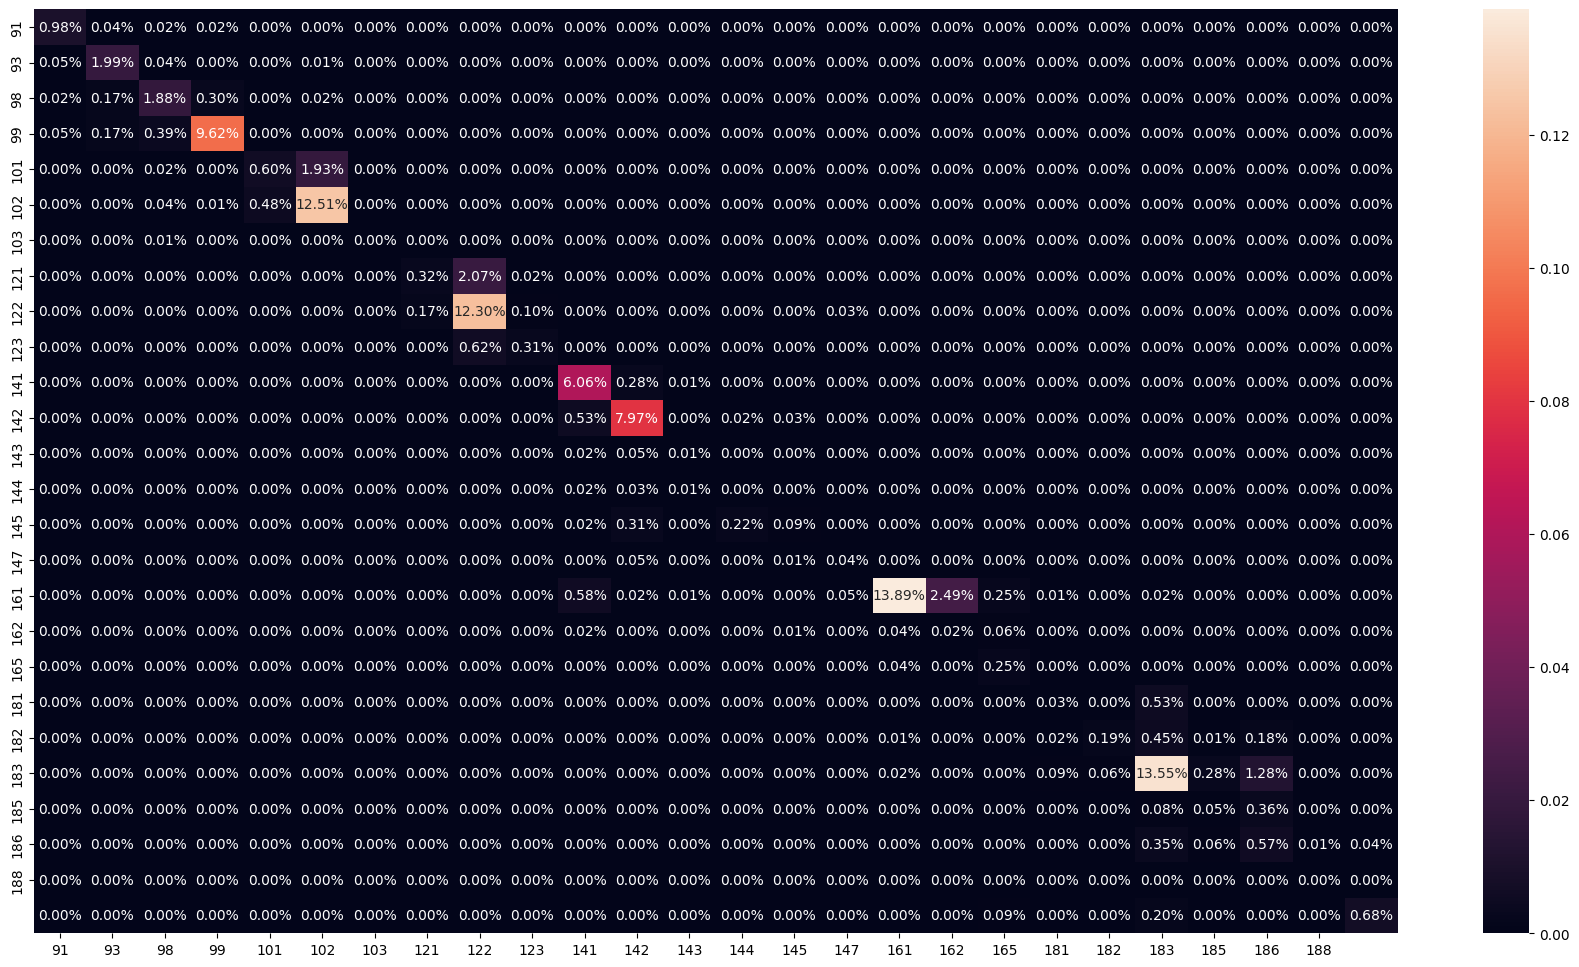

In [ ]:
plt.figure(figsize=(22,12))

categories_present = np.unique(label_encoder_out_of_pyrome.inverse_transform(y_test_encode_out_of_pyrome))
sns.heatmap(out_of_pyrome_metrics['conf'] / np.sum(out_of_pyrome_metrics['conf']),annot=True,fmt='0.2%',xticklabels=categories_present,yticklabels=categories_present)